### 1. Find most frequent products

In [1]:
import pandas as pd 
import numpy as np
from datetime import date,datetime
import csv
import re
from multiprocessing import Pool
from functools import partial
from sklearn import preprocessing
from IPython.core import display as ICD
import matplotlib.pyplot as plt
import itertools
import os
import json
from dateutil.relativedelta import relativedelta
from sklearn import preprocessing

def highlight_max(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    #remove % and cast to float
    data = data.replace('%','', regex=True).astype(float)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)
    
def concat_total_dataset(files_path='../datasets/Total/data'):
    import datetime
    df = pd.DataFrame()
    a = !ls {files_path}
    for i in a:
        df = pd.concat([pd.read_csv(f"../datasets/Total/data/{i}",sep=";"),df])
    df_users = pd.read_csv("../datasets/Total/users.csv",sep=";")
    df = df.merge(df_users,on="CUST_ID")
    df.index = pd.to_datetime(df.TRANSACTION_DATE).dt.to_period("D")
    df["STATION_DEPARTEMENT_ID"] = df.STATION_ID.apply(lambda x : x[3:5])
    df = df[df.STATION_DEPARTEMENT_ID==df.DEPARTEMENT]
    stations = pd.read_csv("../datasets/Total/STATION_TYPE.csv",sep=";")
    df = df.merge(stations,on="STATION_ID").dropna()
    df.index = pd.to_datetime(df.TRANSACTION_DATE).dt.to_period("D")
    df['date'] = pd.to_datetime(df.TRANSACTION_DATE)
    return df
def preprocessing_similar_ids(df,mapping_file_path="../datasets/Total/ids_mapping.json",attribute_name="ARTICLE_ID"):
    with open(mapping_file_path,"r") as f:
        mapping = json.load(f)
        ids = df[attribute_name].astype(str).replace(mapping)
    return ids
items = pd.read_csv("../datasets/Total/items.csv",index_col=0)
items.set_index("ARTICLE_ID",inplace=True)

In [172]:
df = concat_total_dataset()
df.ARTICLE_ID = preprocessing_similar_ids(df)
le = preprocessing.LabelEncoder()
df["ARTICLE_ID"] = le.fit_transform(df["ARTICLE_ID"]) 

stats = df[["ARTICLE_ID"]].asfreq("m").reset_index().groupby("ARTICLE_ID").TRANSACTION_DATE.nunique().to_frame().sort_values("TRANSACTION_DATE",ascending=False)
frequent_items = items.loc[items.index.intersection(le.inverse_transform(stats[:10].index))]
frequent_items.index = le.transform(frequent_items.index)
# frequent_items.loc["# months",stats.index] = stats.TRANSACTION_DATE]
print(f'Total months = {df[["ARTICLE_ID"]].asfreq("m").reset_index().TRANSACTION_DATE.nunique()}')
frequent_items.merge(stats,left_index=True,right_index=True).rename(columns={"TRANSACTION_DATE":"# months"}).sort_values("# months",ascending=False)

Total months = 35


,DESCRIPTION,IDS_LIST,# months
2633,OASIS TROPICAL PET 50CL,[3124480167057],35
4129,REC LAVAGE PJE,[3425909001083],35
4128,REC LAVAGE PJE 35U,[3425909001076],35
4125,RECHARGE LAVAGE TW - A,[3425909001007],35
2946,TW LAVE GLACE,"[3217770310735, 3011449000275, 3217770310759, ...",35
5344,CHOUPETTE 28G L,"[3760145804693, 2100210]",34
1853,CR SANDWICH VOL,"[99999071, 3450011]",34
3882,SDW DAUNAT MIMI,[3367651001891],34
3889,SDW MLX THON OE,[3367651002812],34
6014,TWIX'XTRA 75G,[5900951028502],34


In [181]:
customers = df[(df.SEX=="M")&(df.AGE=="50-65")&(df.DEPARTEMENT=="38")].CUST_ID.unique().tolist()
# df_copy = df.copy()

### Time series creation time

In [7]:
# Database insertion 
from sqlalchemy.exc import IntegrityError
from sqlalchemy import create_engine
import pandas as pd 
import json
import time


engine = create_engine('postgres://miro:@localhost/qetch')
columns = ["sname" , "snum","time","value", "metadata" ]

#### 1. ALL CUSTOMERS DB 

In [183]:
sname ='RAW-DATA'
snum='ALL-CUSTOMERS-DB-1D'

description = "RAW DATA aggregated for a product"
series_type=''

In [184]:
time_stats = []
sizes = []
for idx,row in frequent_items.iterrows(): 
    product_name,product_id = row["DESCRIPTION"].replace("'",""),row.name
    # Frequent DB
    snum=f'ALL-CUSTOMERS-DB-1D {product_name}'
    
    engine.execute(f"delete from measurementseriesdescription where  measurementseries='{snum}'")
    engine.execute(f"delete from measurementdescription where  key='{sname}'")
    engine.execute(f"insert into measurementseriesdescription values ('{sname}','{snum}','{snum}');")
    engine.execute(f"insert into measurementdescription values ('{sname}', '{description}','f','Time' ,'number of customers','date','number','{series_type}');")

    for cpt in range(1,11):
        engine.execute(f"delete from measurement where  snum='{snum}'")
        start_time = time.time()
        engine.execute(f""" 
            insert into measurement
                select 
                '{sname}',
                '{snum}',
                to_date(
                    concat(
                        date_part('year',transaction_date),
                        '-',
                        date_part('doy',transaction_date)
                        ),
                        'YYYY-DDD'
                ) as  time,
                count(cust_id) as value,
                json_build_object(
                    'customers',array_to_string(array_agg( DISTINCT cust_id),',')
                )
                from transactions
                where article_id='{product_id}'
                group by date_part('year',transaction_date), date_part('doy',transaction_date)
            ;
        """)
        execution_time = time.time()-start_time
        time_stats.append((snum,product_name,product_id,cpt,execution_time))
    insertion_size = list(engine.execute(f"SELECT sum(pg_column_size(t.*)) as filesize, count(*) as filerow FROM measurement as t where snum='{snum}';"))
    sizes.append((snum,insertion_size[0][0],insertion_size[0][1],product_name))

#### 2. FREQUENT-DB

In [185]:
sname ='RAW-DATA'
snum='FREQUENT-DB-1D'
target_users = ",".join(f"'{i}'" for i in customers)

description = "FREQUENT DB , raw data aggregated for a product on a subset of customers"
series_type=''

# removing old insertions 


In [186]:
for idx,row in frequent_items.iterrows(): 
    product_name,product_id = row["DESCRIPTION"].replace("'",""),row.name
    snum=f'FREQUENT-DB-1D {product_name}'
    # Frequent DB
    
    engine.execute(f"delete from measurementseriesdescription where  measurementseries='{snum}'")
    engine.execute(f"insert into measurementseriesdescription values ('{sname}','{snum}','{snum}');")
    
    for cpt in range(1,11):
        engine.execute(f"delete from measurement where  snum='{snum}'")
        size_before = list(engine.execute("SELECT pg_size_pretty( pg_total_relation_size('measurement') );"))[0]
        start_time = time.time()
        engine.execute(f""" 
                            insert into measurement
                                select 
                                '{sname}',
                                '{snum}',
                                to_date(
                                    concat(
                                        date_part('year',transaction_date),
                                        '-',
                                        date_part('doy',transaction_date)
                                        ),
                                        'YYYY-DDD'
                                ) as  time,
                                count(cust_id) as value,
                                json_build_object(
                                    'customers',array_to_string(array_agg(DISTINCT cust_id),',')
                                )
                                from transactions
                                where cust_id in ({target_users}) 
                                and article_id='{product_id}'
                                group by date_part('year',transaction_date), date_part('doy',transaction_date)
                            ;
            """)
        execution_time = time.time()-start_time
        time_stats.append((snum,product_name,product_id,cpt,execution_time))
    insertion_size = list(engine.execute(f"SELECT sum(pg_column_size(t.*)) as filesize, count(*) as filerow FROM measurement as t where snum='{snum}';"))
    sizes.append((snum,insertion_size[0][0],insertion_size[0][1],product_name))
    
df = pd.DataFrame(time_stats,columns = ["series","product_name","product_id","cpt","execution_time"])
df["series_name"] = df.series.apply(lambda x : x.split()[0])



In [191]:
def highlight_max(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    #remove % and cast to float
    data = data.replace('%','', regex=True).astype(float)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)
    
df = pd.DataFrame(time_stats,columns = ["series","product_name","product_id","cpt","execution_time"])
df["series_name"] = df.series.apply(lambda x : x.split()[0])
    
stats = df.groupby(["series_name","product_name"]).execution_time.mean().apply(lambda x: round(1000*x))

sizes_stats = pd.DataFrame(sizes,columns=["series","size in db (kb)","#rows","product_name"])
sizes_stats["series_name"] = sizes_stats.series.apply(lambda x : x.split()[0])
sizes_stats.set_index(["series_name","product_name"],inplace=True)
sizes_stats.loc[stats.to_frame().index,"execution_time"]=stats.to_frame().execution_time
sizes_stats = sizes_stats.reset_index().pivot(index="product_name",columns="series_name",values=["#rows","size in db (kb)","execution_time"])
# sizes_stats.astype(str).style.apply(highlight_max)
sizes_stats.fillna(0).astype(int)

#rows                 \
series_name             ALL-CUSTOMERS-DB-1D FREQUENT-DB-1D   
product_name                                                 
CHOUPETTE 28G L                         100              0   
CR SANDWICH VOL                         230              0   
OASIS TROPICAL PET 50CL                 209              2   
REC LAVAGE PJE                          674             17   
REC LAVAGE PJE 35U                      471              8   
RECHARGE LAVAGE TW - A                 1001            378   
SDW DAUNAT MIMI                         241              0   
SDW MLX THON OE                         163              0   
TW  LAVE GLACE                          733             51   
TWIXXTRA 75G                            193              1   

                            size in db (kb)                 \
series_name             ALL-CUSTOMERS-DB-1D FREQUENT-DB-1D   
product_name                                                 
CHOUPETTE 28G L                       11367              0   
CR SANDWICH VOL                       26309              0   
OASIS TROPICAL PET 50CL               25469            223   
REC LAVAGE PJE                        80244           1783   
REC LAVAGE PJE 35U                    54807            902   
RECHARGE LAVAGE TW - A               202515          43616   
SDW DAUNAT MIMI                       27545              0   
SDW MLX THON OE                       18544              0   
TW  LAVE GLACE                        96766           5380   
TWIXXTRA 75G                          22053            102   

                             execution_time                 
series_name             ALL-CUSTOMERS-DB-1D FREQUENT-DB-1D  
product_name                                                
CHOUPETTE 28G L                          22             36  
CR SANDWICH VOL                          22             39  
OASIS TROPICAL PET 50CL                  21             35  
REC LAVAGE PJE                           29             47  
REC LAVAGE PJE 35U                       28             47  
RECHARGE LAVAGE TW - A                   44            202  
SDW DAUNAT MIMI                          23             31  
SDW MLX THON OE                          22             30  
TW  LAVE GLACE                           32             61  
TWIXXTRA 75G                             24             30

## Running queries

In [8]:
from selenium.webdriver import Chrome
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as ec
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
snum ='ALL-CUSTOMERS-DB-1D OASIS TROPICAL PET 50CL'

In [9]:
rs = engine.execute('select distinct snum from measurement;')
snums = [i[0] for i in rs]
query_name = "shape query"
snums

['ALL-CUSTOMERS-DB-1D CHOUPETTE 28G L',
 'ALL-CUSTOMERS-DB-1D CR SANDWICH VOL',
 'ALL-CUSTOMERS-DB-1D RECHARGE LAVAGE TW - A',
 'FREQUENT-DB-1D REC LAVAGE PJE',
 'FREQUENT-DB-1D RECHARGE LAVAGE TW - A',
 'ALL-CUSTOMERS-DB-1D TWIXXTRA 75G',
 'ALL-CUSTOMERS-DB-1D SDW DAUNAT MIMI',
 'FREQUENT-DB-1D TW  LAVE GLACE',
 'FREQUENT-DB-1D REC LAVAGE PJE 35U',
 'ALL-CUSTOMERS-DB-1D REC LAVAGE PJE 35U',
 'ALL-CUSTOMERS-DB-1D REC LAVAGE PJE',
 'FREQUENT-DB-1D OASIS TROPICAL PET 50CL',
 'ALL-CUSTOMERS-DB-1D TW  LAVE GLACE',
 'ALL-CUSTOMERS-DB-1D OASIS TROPICAL PET 50CL',
 'ALL-CUSTOMERS-DB-1D SDW MLX THON OE',
 'FREQUENT-DB-1D TWIXXTRA 75G']

In [276]:
driver = Chrome()
driver.get("http://127.0.0.1:2048/")
driver.maximize_window()


results1 = []
for snum in snums :
    driver.get("http://127.0.0.1:2048/")
    WebDriverWait(driver, 10).until(
        ec.presence_of_element_located(
            (By.XPATH, "//span[contains(text(),'choose')]"))
    ).click()



    WebDriverWait(driver, 10).until(
        ec.presence_of_element_located(
            (By.XPATH, f"//li/a[contains(.,'{snum}')]"))
    ).click()

    driver.implicitly_wait(2)
    WebDriverWait(driver, 10).until(
        ec.presence_of_element_located(
            (By.CSS_SELECTOR, "#customers"))
    ).clear()

    for cpt in range(1,11):
        WebDriverWait(driver, 10).until(ec.presence_of_element_located((By.CSS_SELECTOR, ".glyphicon.glyphicon-erase"))           ).click()
        canvas = WebDriverWait(driver, 10).until(
            ec.presence_of_element_located(
                (By.CSS_SELECTOR, "#dataSetQueryCanvas"))
        )

        drawing = ActionChains(driver)\
            .click_and_hold(canvas)\
            .move_by_offset(0, 50)\
            .move_by_offset(10, -50)\
            .release()
        drawing.perform()

        query_results = driver.find_element_by_css_selector("#rawMatches").get_attribute('value')
        query_time = driver.find_element_by_css_selector("#Rtime").get_attribute('value')
        results1.append((cpt, snum,query_results,query_time))
driver.close()

ElementNotInteractableException: Message: element not interactable
  (Session info: chrome=81.0.4044.138)


In [ ]:
df1 = pd.DataFrame(results1,columns=['cpt','series','results','time']).replace(r'^\s*$', np.nan, regex=True).dropna(subset=['time'])
df1.time = df1.time.astype(float).apply(lambda x : round(x,2))
df1.results = df1.results.apply(json.loads).apply(len)
df1 = df1.groupby('series').agg({"results":["mean"],"time":["mean","std"]})
df1["query_name"] = "shape query"
df1.loc[:,[("time","std")]] = df1.loc[:,[("time","std")]].apply(lambda x : round(x,2))
df1.loc[:,[("time","mean")]] = df1.loc[:,[("time","mean")]].apply(lambda x : round(x,2))
df1.to_csv("shape_query.csv")
df1

results              time           
                                       mean       std    mean        std
series_name         product_name                                        
ALL-CUSTOMERS-DB-1D CHOUPETTE 28G L       8  0.000000   2.135   1.523273
                    CR SANDWICH VOL      43  2.828427  27.140  25.738687

### Shape and customers query

In [ ]:
query_name = "shape and customers"

In [ ]:
driver = Chrome()
driver.get("http://127.0.0.1:2048/")
driver.maximize_window()

results2 = []

for snum in snums :
    driver.get("http://127.0.0.1:2048/")
    WebDriverWait(driver, 10).until(
        ec.presence_of_element_located(
            (By.XPATH, "//span[contains(text(),'choose')]"))
    ).click()

    WebDriverWait(driver, 10).until(
        ec.presence_of_element_located(
            (By.XPATH, f"//li/a[contains(.,'{snum}')]"))
    ).click()

    driver.implicitly_wait(2)
    for cpt in range(1,11):
        WebDriverWait(driver, 10).until(ec.presence_of_element_located((By.CSS_SELECTOR, ".glyphicon.glyphicon-erase"))           ).click()
        canvas = WebDriverWait(driver, 10).until(
            ec.presence_of_element_located(
                (By.CSS_SELECTOR, "#dataSetQueryCanvas"))
        )

        drawing = ActionChains(driver)\
            .click_and_hold(canvas)\
            .move_by_offset(0, 50)\
            .move_by_offset(10, -50)\
            .release()
        drawing.perform()

        query_results = driver.find_element_by_css_selector("#rawMatches").get_attribute('value')
        query_time = driver.find_element_by_css_selector("#Rtime").get_attribute('value')
        results2.append((cpt, snum,query_results,query_time))
driver.close()

In [ ]:
df2= pd.DataFrame(results2,columns=['cpt','series','results','time']).replace(r'^\s*$', np.nan, regex=True).dropna(subset=['time'])
df2.time = df2.time.astype(float).apply(lambda x : round(x,2))
df2.results = df2.results.apply(json.loads).apply(len)
df2 = df2.groupby('series').agg({"results":["mean"],"time":["mean","std"]})
df2["query_name"] = "shape and customers query"
df2.loc[:,[("time","std")]] = df2.loc[:,[("time","std")]].apply(lambda x : round(x,2))
df2.loc[:,[("time","mean")]] = df2.loc[:,[("time","mean")]].apply(lambda x : round(x,2))
df2.to_csv("shape_customers_query.csv")
df2

In [254]:
all_results = pd.concat([df1,df2],axis=0)
all_results["series_name"],all_results["product_name"] = all_results.index.to_series().apply(lambda x : x.split()[0]),all_results.index.to_series().apply(lambda x :" ".join(x.split()[1:]))
all_results.columns = [' '.join(col).strip() for col in all_results.columns.values]

all_results.reset_index().pivot(index=["series_name","product_name"],values=["results mean","time mean","time std"],columns="series")

ValueError: Shape of passed values is (30, 3), indices imply (2, 3)

In [255]:
all_results.head()

,query_name,results mean,series_name,time mean,time std,product_name
series,,,,,,
ALL-CUSTOMERS-DB-1D CHOUPETTE 28G L,shape query,8,ALL-CUSTOMERS-DB-1D,2.27,1.39,CHOUPETTE 28G L
ALL-CUSTOMERS-DB-1D CR SANDWICH VOL,shape query,41,ALL-CUSTOMERS-DB-1D,6.43,2.39,CR SANDWICH VOL
ALL-CUSTOMERS-DB-1D OASIS TROPICAL PET 50CL,shape query,25,ALL-CUSTOMERS-DB-1D,5.74,4.76,OASIS TROPICAL PET 50CL
ALL-CUSTOMERS-DB-1D REC LAVAGE PJE,shape query,93,ALL-CUSTOMERS-DB-1D,21.87,7.99,REC LAVAGE PJE
ALL-CUSTOMERS-DB-1D REC LAVAGE PJE 35U,shape query,71,ALL-CUSTOMERS-DB-1D,13.50,4.90,REC LAVAGE PJE 35U


In [274]:
res1 = all_results[all_results.query_name=="shape query"].pivot(index="product_name",values=["results mean","time mean","time std"],columns="series_name",).fillna(0)
res1.columns = [' '.join(col).strip() for col in res1.columns.values]
res1[[i for i in res1.columns if "results" in i ]] = res1[[i for i in res1.columns if "results" in i ]].astype(int)
res1

,results mean ALL-CUSTOMERS-DB-1D,results mean FREQUENT-DB-1D,time mean ALL-CUSTOMERS-DB-1D,time mean FREQUENT-DB-1D,time std ALL-CUSTOMERS-DB-1D,time std FREQUENT-DB-1D
product_name,,,,,,
CHOUPETTE 28G L,8,0,2.27,0.00,1.39,0.00
CR SANDWICH VOL,41,0,6.43,0.00,2.39,0.00
OASIS TROPICAL PET 50CL,25,0,5.74,0.24,4.76,0.26
REC LAVAGE PJE,93,0,21.87,0.30,7.99,0.30
REC LAVAGE PJE 35U,71,0,13.50,0.17,4.90,0.05
RECHARGE LAVAGE TW - A,91,73,38.03,10.95,11.55,3.32
SDW DAUNAT MIMI,48,0,9.92,0.00,2.55,0.00
SDW MLX THON OE,28,0,5.00,0.00,1.95,0.00
TW LAVE GLACE,89,2,23.62,0.77,11.94,0.88


In [275]:
res1 = all_results[all_results.query_name=="shape and customers query"].pivot(index="product_name",values=["results mean","time mean","time std"],columns="series_name",).fillna(0)
res1.columns = [' '.join(col).strip() for col in res1.columns.values]
res1[[i for i in res1.columns if "results" in i ]] = res1[[i for i in res1.columns if "results" in i ]].astype(int)
res1

,results mean ALL-CUSTOMERS-DB-1D,results mean FREQUENT-DB-1D,time mean ALL-CUSTOMERS-DB-1D,time mean FREQUENT-DB-1D,time std ALL-CUSTOMERS-DB-1D,time std FREQUENT-DB-1D
product_name,,,,,,
CHOUPETTE 28G L,0,0,3.34,0.00,0.91,0.00
CR SANDWICH VOL,0,0,11.70,0.00,3.68,0.00
OASIS TROPICAL PET 50CL,2,0,9.49,0.17,2.00,0.08
REC LAVAGE PJE,14,0,44.50,0.28,8.07,0.23
REC LAVAGE PJE 35U,6,0,26.20,0.23,5.24,0.07
RECHARGE LAVAGE TW - A,83,73,113.62,21.03,18.39,5.24
SDW DAUNAT MIMI,0,0,18.19,0.00,6.88,0.00
SDW MLX THON OE,0,0,7.41,0.00,2.95,0.00
TW LAVE GLACE,22,2,46.48,1.15,9.09,0.58


In [72]:
a = [[1,2],[1,"2"]]
pd.DataFrame(a,dtype=np.dtype(('str','int')]))

TypeError: data type not understood

### Sliding windows data insertions form csv file 

In [103]:
sname = "RAW-SLIDING_WINDOWS"

#Delete old ones 
engine.execute(f"delete from measurement where sname='{sname}'")

In [104]:
df = pd.read_csv('../plots/qetch/7D-30-[1-10]-[SEX]-lcm.out-raw-sliding_windows.csv')
df.customers = df.customers.apply(lambda x: dict(customers=x) ).apply(json.dumps)
df.granularity = df.granularity.apply(lambda x: f'{sname}-{x}')
df["sname"] = sname

df.rename(columns = {
    "period_y":"time",
    "interest_gain":"value",
    "customers":"metadata",
    "granularity":"snum"
},inplace=True)
df.head()

,time,value,metadata,snum,sname
0,2018-07-15,6,"{""customers"": ""[612824, 118478, 739860, 403445...",RAW-SLIDING_WINDOWS-1W,RAW-SLIDING_WINDOWS
1,2018-07-22,5,"{""customers"": ""[607784, 464331, 270220, 368080...",RAW-SLIDING_WINDOWS-1W,RAW-SLIDING_WINDOWS
2,2018-07-29,5,"{""customers"": ""[607784, 464331, 270220, 368080...",RAW-SLIDING_WINDOWS-1W,RAW-SLIDING_WINDOWS
3,2018-08-05,6,"{""customers"": ""[235297, 607784, 464331, 270220...",RAW-SLIDING_WINDOWS-1W,RAW-SLIDING_WINDOWS
4,2018-08-12,0,"{""customers"": ""[]""}",RAW-SLIDING_WINDOWS-1W,RAW-SLIDING_WINDOWS


In [105]:
import time
start_time = time.time()
df.to_sql("measurement",con=engine,if_exists="append",index=False)
print("insertion of ",df.shape," In time : ",time.time() - start_time)


insertion of  (158, 5)  In time :  0.030074357986450195


In [106]:
# removing olds to avoi
try:

    series_description = df[["snum","sname"]].drop_duplicates().rename(columns = {"snum":'measurementseries',"sname":"measurementkey"})
    series_description["description"] = series_description["measurementseries"] 
    series_description.to_sql("measurementseriesdescription",con=engine,if_exists="append",index=False)
    series_description
except Exception as e:
    print(e)

### Raw data insertion from cv 


In [107]:
sname = "RAW"

#Delete old ones 
engine.execute(f"delete from measurement where sname='{sname}'")

In [108]:
df = pd.read_csv('../plots/qetch/7D-30-[1-10]-[SEX]-lcm.out-raw.csv',index_col=0)
df.CUST_ID= df.CUST_ID.apply(lambda x : f'[{",".join(x[1:-1].split())}]')
df["interest_gain"] = df.CUST_ID.apply(len)
df.CUST_ID = df.CUST_ID.apply(lambda x: dict(customers=x)).apply(json.dumps)
df.granularity = df.granularity.apply(lambda x: f'{sname}-{x}')
df["sname"] = sname
df.rename(columns = {
    "index":"time",
    "interest_gain":"value",
    "CUST_ID":"metadata",
    "granularity":"snum"
},inplace=True)
df.to_sql("measurement",con=engine,if_exists="append",index=False)

In [109]:
try:
    series_description = df[["snum","sname"]].drop_duplicates().rename(columns = {"snum":'measurementseries',"sname":"measurementkey"})
    series_description["description"] = series_description["measurementseries"] 
    series_description.to_sql("measurementseriesdescription",con=engine,if_exists="append",index=False)
except Exception as e:
    print(e)

### ALL CUSTOMERS DB and FREQUENT DB 

Parameters : 
## Customers  : 100
## Product name : Recharge afe club, product id : 1538


### Frequent DB

In [129]:
# Frequent DB
sname ='RAW-SUBSET'
snum='RAW-SUBSET-1D'
description = "FREQUENT DB , raw data aggregated for a product on a subset of customers"
series_type=''

# removing old insertions 
engine.execute(f"delete from measurement where  sname='{sname}'")
engine.execute(f"delete from measurementseriesdescription where  measurementseries='{snum}'")
engine.execute(f"delete from measurementdescription where  key='{sname}'")

start_time = time.time()
engine.execute(f""" 
    insert into measurement
        select 
        '{sname}',
        '{snum}',
        to_date(
            concat(
                date_part('year',transaction_date),
                '-',
                date_part('doy',transaction_date)
                ),
                'YYYY-DDD'
        ) as  time,
        count(cust_id) as value,
        json_build_object(
            'customers',array_to_string(array_agg(cust_id),',')
        )
        from transactions
        where cust_id in ({target_users}) 
        and article_id='{product_id}'
        group by date_part('year',transaction_date), date_part('doy',transaction_date)
    ;
""")
a = [i for i in engine.execute(f"select count(*) from measurement  where  snum='{snum}'")]
print("insertion of ",a," In time : ",time.time() - start_time)
engine.execute(f"insert into measurementseriesdescription values ('{sname}','{snum}','{snum}');")
engine.execute(f"insert into measurementdescription values ('{sname}', '{description}','f','Time' ,'number of customers','date','number','{series_type}');")


insertion of  [(90,)]  In time :  0.08256316184997559


## ALL CUSTOMERS DB 

In [130]:
# Frequent DB
sname ='RAW'
snum='RAW-1D'
description = "ALL CUSTOMERS DB , raw data aggregated for a product on all customers"
series_type=''
# removing old insertions 
engine.execute(f"delete from measurement where  sname='{sname}'")
engine.execute(f"delete from measurementseriesdescription where  measurementseries='{snum}'")
engine.execute(f"delete from measurementdescription where  key='{sname}'")

start_time = time.time()
engine.execute(f""" 
    insert into measurement
        select 
        '{sname}',
        '{snum}',
        to_date(
            concat(
                date_part('year',transaction_date),
                '-',
                date_part('doy',transaction_date)
                ),
                'YYYY-DDD'
        ) as  time,
        count(cust_id) as value,
        json_build_object(
            'customers',array_to_string(array_agg(cust_id),',')
        )
        from transactions
        where article_id='{product_id}'
        group by date_part('year',transaction_date), date_part('doy',transaction_date)
    ;
""")
a = [i for i in engine.execute(f"select count(*) from measurement  where  snum='{snum}'")]
print("insertion of ",a," In time : ",time.time() - start_time)
engine.execute(f"insert into measurementseriesdescription values ('{sname}','{snum}','RAW-1D');")
engine.execute(f"insert into measurementdescription values ('{sname}', '{description}','f','Time' ,'number of customers','date','number','{series_type}');")


insertion of  [(183,)]  In time :  0.07910799980163574


### Queries results stats

In [323]:
def format_result(results):
    df = pd.DataFrame(results)
    df['value'] = df.customers.apply(len)
    df = df.sort_values(["date",'value']).drop_duplicates(subset=["date"],keep='last')
    df.date = pd.to_datetime(df.date).dt.date
    return df

### 1. Shape query
* All customers DB query 
* Frequent DB

In [553]:

results = [{"customers":[770747,975853,339445,204400,203468,539857,907465,1048263,261384],"date":"2018-05-14T22:00:00.000Z","duration":"2 days"},{"customers":[342130,1001471,337630,864948],"date":"2018-05-20T22:00:00.000Z","duration":"1 days"},{"customers":[868873,150337,340295,537580,875771,533921,133113,511179],"date":"2018-05-24T22:00:00.000Z","duration":"4 days"},{"customers":[546403,1058945,915181,249608,289781,234661,741468],"date":"2018-06-13T22:00:00.000Z","duration":"5 days"},{"customers":[280868,199036,988004],"date":"2018-06-19T22:00:00.000Z","duration":"1 days"},{"customers":[992235,199892,459933,984430,1091087,122130],"date":"2018-06-21T22:00:00.000Z","duration":"5 days"},{"customers":[916607,984430,519310,194469,114666,579128,187833],"date":"2018-06-30T22:00:00.000Z","duration":"4 days"},{"customers":[322146,251568,451363,433654,1095891,751640,203089,739860,915181,427096],"date":"2018-07-06T22:00:00.000Z","duration":"3 days"},{"customers":[280536,118478,612824,187833,314647,602580,425954,903640,453193,427096,721566,739860,297364],"date":"2018-07-10T22:00:00.000Z","duration":"1 days"},{"customers":[776250,776030,453193,634606,147589,110899,105293,319630,307173,1095891,187833,573259,235462,368080,314647],"date":"2018-07-13T22:00:00.000Z","duration":"3 days"},{"customers":[604098,314647,280766,607784,403445,435229,427250,453193,751640,609497,131325,427921],"date":"2018-07-18T22:00:00.000Z","duration":"1 days"},{"customers":[911619,804991,427096,453193,427250,1087105,342688,671878,314647,957469,118478,392366,1106546,149963,602580,751640],"date":"2018-07-22T22:00:00.000Z","duration":"3 days"},{"customers":[372524,588437,460754,199984,432305,235297,118478,193871,307173,567787,453193,261752],"date":"2018-07-28T22:00:00.000Z","duration":"2 days"},{"customers":[604098,588437,427250,286637,110073],"date":"2018-08-01T22:00:00.000Z","duration":"1 days"},{"customers":[758478,351686,434667,1065901,720284,722159,610292,199984,215849],"date":"2018-08-06T22:00:00.000Z","duration":"3 days"},{"customers":[777319,296343,528367,218865],"date":"2018-08-15T22:00:00.000Z","duration":"1 days"},{"customers":[466937,110899,147410,483545,519327,187833,296343,449488,314647],"date":"2018-08-18T22:00:00.000Z","duration":"2 days"},{"customers":[1167617,777319,318677,397035,427096],"date":"2018-08-22T22:00:00.000Z","duration":"1 days"},{"customers":[187833,199984,418074,114666,453193,562620,521982,110899,296343,1180356],"date":"2018-08-24T22:00:00.000Z","duration":"3 days"},{"customers":[187833,1163691,457591,427250,681522,453193,602580,425954,351686,147410,194469,307173,320151,751640],"date":"2018-08-28T22:00:00.000Z","duration":"1 days"},{"customers":[751640,915181,777319,425954,464331,133113,163470,108938,1095891,957469,110899,1166148,451363,1163691,292347,199984],"date":"2018-09-04T22:00:00.000Z","duration":"1 days"},{"customers":[559713,133892,432305,483533,607784,1167617,371456,903640,445481,1166148,427921,381915,777319],"date":"2018-09-09T22:00:00.000Z","duration":"1 days"},{"customers":[1086230,427250,419944,915181,244827,114666,751640],"date":"2018-09-15T22:00:00.000Z","duration":"1 days"},{"customers":[573259,453193,604098,403445,270220,114666,1166148,235297,903640,451363,249000,1084524],"date":"2018-09-19T22:00:00.000Z","duration":"1 days"},{"customers":[1196697,1168767,114666,118478,1030310,314647,187833,453193,244827,427250,110899,523545,149963,1198352,602580,607784,1166148,235297,368080,425954,1095891,138170,325309,403445,805158,521982],"date":"2018-09-21T22:00:00.000Z","duration":"4 days"},{"customers":[751640,1166148,307173,903640,451363,100194,314647,607784,1196697,110899,1095891,1163691,244827,403445,187833,612824,483533,327909],"date":"2018-09-26T22:00:00.000Z","duration":"1 days"},{"customers":[110899,1095891,1163691,244827,403445,187833,612824,751640,483533,327909,1168767,1204127,607784,1196697,1166148,451363,270220,870253,453193,425954,235297,161394,127790,957469,413059,520599,409613,1045120,118478,423574,575523,156514,739860,432305,314647,370988,199984,464331,304712,903640,1206265],"date":"2018-09-27T22:00:00.000Z","duration":"5 days"},{"customers":[612824,368080,446043,403445,1095891,1163691,156634,329711,187833,519327,270220,960639,375021,147410,453193,957469,427250,804991,451363,162567,427096],"date":"2018-10-03T22:00:00.000Z","duration":"1 days"},{"customers":[1167207,427250,607784,739860,270220,1045120,1042827,870253,1205586,741170,314647,957469,325309,1166148,519327,552846,368080,292347],"date":"2018-10-08T22:00:00.000Z","duration":"1 days"},{"customers":[449529,464331,1167207,755525,1168767,325309,244827,1205586,427096,133892,270220,1206265,552846,946527,1042614,444802,607784,1045120,127790,1103098],"date":"2018-10-12T22:00:00.000Z","duration":"2 days"},{"customers":[612824,1163691,427921,109730,1196697,271779,519327,915181,235297,1205586,449529,1166148,325309,261384,427250,370988,1206265,552846,445481,874736,127790,270220],"date":"2018-10-15T22:00:00.000Z","duration":"1 days"},{"customers":[1168767,606762,1163691,1166148,519327,1206265,110899,805158,1095891,739860,453193,199984,254475,235297,346427,612824,427096,270220,464331,329014,552846,308992,156634],"date":"2018-10-20T22:00:00.000Z","duration":"2 days"},{"customers":[1106966,1178295,957469,483533,187833,368080,403445,915181,346289,329014,114666,999796,270220,464331,552846,1070572,427921,1166148,453193],"date":"2018-10-23T22:00:00.000Z","duration":"1 days"},{"customers":[1168767,100194,1206265,275782,270220,552846,110899,127790,999796,210939,427250],"date":"2018-10-27T22:00:00.000Z","duration":"1 days"},{"customers":[1206265,607784,314647,114666,270220,425954,521982,453193,523545],"date":"2018-11-04T23:00:00.000Z","duration":"1 days"},{"customers":[1206265,114666,446043,156634,1163691,261384,592984,235297,604098,270220,325309,161394,199984,453193,607784,915181,1196697,424345,133070,488821,1056892,1095891,187833,489993,1198352,118478,590883,368080,1061637,127790,147410,460228],"date":"2018-11-06T23:00:00.000Z","duration":"2 days"},{"customers":[425954,786504,251568,210939,1166148,596217,149963,1205586,751640,950817,552846,1206265],"date":"2018-11-09T23:00:00.000Z","duration":"2 days"},{"customers":[604098,1095891,187833,325309,1196697,308992,453193,1166148,1206265,455360,427250,600467,320135,235297,329014,1205586,156634,133070,368080,280536,1180756,114666,751640,607784,999796],"date":"2018-11-12T23:00:00.000Z","duration":"1 days"},{"customers":[1227762,118478,519327,1206265,127790,147410,552846,1011028,1205586,156634,308992,875601,368080,270220,739860,453193,464331],"date":"2018-11-18T23:00:00.000Z","duration":"1 days"},{"customers":[1206265,127790,1095891,1171591,1166148,607223,636341,1061637,1163691,602580,519327,777319,739860,149963,450658,616689,425954,244827,156634,1205586,453193,446043,552846,270220,1196697,612824,163470,751640],"date":"2018-11-20T23:00:00.000Z","duration":"2 days"},{"customers":[1168767,731934,325309,451363,1198352,205109,272472,251568,1206265,100194,521982,1196697,1095891,156634,127790,874736,127760,109054,1166148,442885,552846,1205586,1171591,155063,746930,244827,147410,600467,1237802,1180756,308992,453193,114666,556062,427096],"date":"2018-11-23T23:00:00.000Z","duration":"4 days"},{"customers":[552846,344696,205109,1205586,308992,118478,449531,739860,187833,1171591,1180756,751640,453193,1206265,1186493,1167207,109054,607784,127790,154300],"date":"2018-11-28T23:00:00.000Z","duration":"1 days"},{"customers":[1168767,1095891,957469,251568,133892,1206265,1099020,308992,612824,109730,589209,205109,607784,110899,446043,1045120,777319,427096,118478,328183,235297,1061637,187833,127760,1171591,1166148,943482,349732,175853,424345,616689,307173,1198352,464331,127790,602580],"date":"2018-11-30T23:00:00.000Z","duration":"5 days"},{"customers":[573355,616689,751640,251568,324605,464331,449529,1206265,607784,244827,114666,777319,275782,270220,368080,915181,489993,339011,1095891,403445,308992,1163691,1180756,147410,314647,1122125,1045120],"date":"2018-12-07T23:00:00.000Z","duration":"3 days"},{"customers":[489993,118478,110899,1166148,346427,898933,612824,114666,777319,156634,446043,329014,616689,751640,427096,1180756,270220,251568,1206265],"date":"2018-12-12T23:00:00.000Z","duration":"1 days"},{"customers":[1171591,739860,108938,187833,957469,275782,259132,308992,251568,1206265,325309,292347,453193],"date":"2018-12-14T23:00:00.000Z","duration":"2 days"},{"customers":[270220,915181,442885,146208,1198352,149963,427096,1180756,751640,739860,1056892,453193,156634,552846,308992,612824,984661,1206265,1196697,1205586,574696,497674,329014,127790,460228,1095891,1061637,235297],"date":"2018-12-17T23:00:00.000Z","duration":"1 days"},{"customers":[497696,110899,1166148,1206265,1045120,915181],"date":"2018-12-23T23:00:00.000Z","duration":"2 days"},{"customers":[449529,1205586,140167,552846,109054,144552,1045120,539294],"date":"2018-12-26T23:00:00.000Z","duration":"1 days"},{"customers":[624106,342130,1001471,337630,864948,209794,329014,138017,510973,868873,150337,340295,537580,875771],"date":"2018-05-18T22:00:00.000Z","duration":"7 days"},{"customers":[776832,430391,546403,1058945,915181,249608,289781,234661,741468,280868,199036,988004,992235,199892],"date":"2018-06-11T22:00:00.000Z","duration":"10 days"},{"customers":[1171591,777319,118478,292347,1095891,870253,162402,804991,100194,915181,1166148,296343,114666,521982,429617,187833,751640,425954,464331,133113],"date":"2018-08-30T22:00:00.000Z","duration":"5 days"},{"customers":[581051,602580,541985,751640,389285,1167207,559713,133892,432305,483533,607784,1167617,371456,903640,445481,1166148,427921,381915,777319,1061637,453193,451363,114666,521982,187833,296343,368080],"date":"2018-09-06T22:00:00.000Z","duration":"5 days"},{"customers":[187833,108938,478931,118478,675528,911967,622271,1168767,183631,1103098,199021,552846,1205586,612824,130532,1178295,1045120,1061637,138170,1166148,776030,314647,1167207,427250,607784,739860,270220,1042827,870253,741170,957469,325309,519327,368080,292347,446043,274754,1196697,451363,133892,156634],"date":"2018-10-05T22:00:00.000Z","duration":"5 days"},{"customers":[255972,1206265,607784,314647,114666,270220,425954,521982,453193,523545,446043,156634,1163691,261384,592984,235297,604098,325309,161394,199984,915181,1196697],"date":"2018-10-30T23:00:00.000Z","duration":"8 days"},{"customers":[425954,786504,251568,210939,1166148,596217,149963,1205586,751640,950817,552846,1206265,604098,1095891,187833,325309,1196697,308992,453193,455360,427250,600467,320135,235297,329014,156634,133070,368080,280536,1180756,114666,607784,999796,521982,133892,865313,1061637,1171591],"date":"2018-11-09T23:00:00.000Z","duration":"5 days"},{"customers":[1001471,337630,864948,209794,329014,138017,510973,868873,150337,340295,537580,875771],"date":"2018-05-21T22:00:00.000Z","duration":"4 days"},{"customers":[105661,681336,916607,984430,519310,194469,114666,579128,187833,607784,922480,616689,322146,251568,451363,433654,1095891,751640,203089,739860,915181,427096,280536,118478,612824],"date":"2018-06-28T22:00:00.000Z","duration":"12 days"},{"customers":[777319,296343,528367,218865,985441,466937,110899,147410,483545,519327,187833,449488,314647],"date":"2018-08-15T22:00:00.000Z","duration":"5 days"},{"customers":[1167617,777319,318677,397035,427096,187833,199984,418074,114666,453193,562620,521982,110899,296343,1180356,1163691,457591,427250,681522,602580,425954,351686,147410,194469,307173,320151,751640,1171591,118478,292347,1095891,870253,162402,804991,100194,915181,1166148,429617,464331,133113],"date":"2018-08-22T22:00:00.000Z","duration":"13 days"},{"customers":[187833,108938,478931,118478,675528,911967,622271,1168767,183631,1103098,199021,552846,1205586,612824,130532,1178295,1045120,1061637,138170,1166148,776030,314647,1167207,427250,607784,739860,270220,1042827,870253,741170,957469,325309,519327,368080,292347,446043,274754,1196697,451363,133892,156634,530814,403445,1095891,483533,149963,307173,535838,453193,1206265,163470,1171591,449529,464331,755525,244827,427096,946527,1042614,444802,127790,1163691,427921,109730,271779,915181],"date":"2018-10-05T22:00:00.000Z","duration":"10 days"},{"customers":[100194,1206265,275782,270220,552846,110899,127790,999796,210939,427250,255972,607784,314647,114666,425954,521982,453193,523545,446043,156634,1163691,261384,592984,235297,604098,325309,161394,199984,915181,1196697,424345,133070,488821,1056892,1095891,187833,489993,1198352,118478,590883,368080,1061637,147410,460228,786504,251568,1166148,596217,149963,1205586,751640,950817,308992,455360,600467,320135,329014,280536,1180756,133892,865313,1171591],"date":"2018-10-28T23:00:00.000Z","duration":"17 days"},{"customers":[770747,975853,339445,204400,203468,539857,907465,1048263,261384,624106,342130,1001471,337630,864948,209794,329014,138017,510973,868873,150337],"date":"2018-05-14T22:00:00.000Z","duration":"10 days"},{"customers":[576831,869738,776832,430391,546403,1058945,915181,249608,289781,234661,741468,280868,199036,988004,992235,199892,459933,984430,1091087,122130,105661,681336,916607,519310,194469,114666,579128,187833,607784,922480,616689,322146,251568,451363,433654,1095891,751640,203089,739860,427096,280536,118478,612824,314647,602580,425954,903640,453193,721566,297364,403445,776250,776030,634606,147589,110899,105293,319630,307173,573259,235462,368080],"date":"2018-06-09T22:00:00.000Z","duration":"37 days"},{"customers":[777319,296343,528367,218865,985441,466937,110899,147410,483545,519327,187833,449488,314647,196577,188588,1168767,540942,1167617,318677,397035,427096,199984,418074,114666,453193,562620,521982,1180356,1163691,457591,427250,681522,602580,425954,351686,194469,307173,320151,751640,1171591,118478,292347,1095891,870253,162402,804991,100194,915181,1166148,429617,464331,133113,163470,108938,957469,451363,581051,541985,389285,1167207,559713,133892,432305,483533],"date":"2018-08-15T22:00:00.000Z","duration":"25 days"},{"customers":[403445,270220,114666,1166148,235297,903640,451363,249000,1084524,1196697,1168767,118478,1030310,314647,187833,453193,244827,427250,110899,523545,149963,1198352,602580,607784,368080,425954,1095891,138170,325309,805158,521982,751640,307173,100194,1163691,612824,483533,327909,1204127,870253,161394,127790,957469,413059,520599,409613,1045120,423574,575523],"date":"2018-09-20T22:00:00.000Z","duration":"11 days"},{"customers":[1168767,1095891,957469,251568,133892,1206265,1099020,308992,612824,109730,589209,205109,607784,110899,446043,1045120,777319,427096,118478,328183,235297,1061637,187833,127760,1171591,1166148,943482,349732,175853,424345,616689,307173,1198352,464331,127790,602580,114666,453193,296343,552846,421137,108938,1196697,325309,573355,751640,324605,449529,244827,275782,270220,368080,915181],"date":"2018-11-30T23:00:00.000Z","duration":"9 days"},{"customers":[738557,777319,296343,528367,218865,985441,466937,110899,147410,483545,519327,187833,449488,314647,196577,188588,1168767,540942,1167617,318677,397035,427096,199984,418074,114666,453193,562620,521982,1180356,1163691,457591,427250,681522,602580,425954,351686,194469,307173,320151,751640,1171591,118478,292347,1095891,870253,162402,804991,100194,915181,1166148,429617,464331,133113,163470,108938,957469,451363,581051,541985,389285,1167207],"date":"2018-08-14T22:00:00.000Z","duration":"23 days"},{"customers":[1167207,427096,368080,879803,573259,751640,521982,607784,453193,604098,403445,270220,114666,1166148,235297,903640,451363,249000,1084524,1196697,1168767,118478,1030310,314647,187833,244827,427250,110899,523545,149963,1198352,602580,425954,1095891,138170,325309,805158,307173,100194,1163691,612824,483533,327909,1204127,870253,161394,127790,957469,413059,520599,409613,1045120,423574,575523,156514,739860,432305,370988,199984,464331,304712,1206265,446043,156634,329711,519327,960639,375021,147410,804991,162567,108938,478931,675528,911967,622271,183631,1103098,199021,552846,1205586,130532,1178295,1061637,776030,1042827,741170,292347,274754,133892,530814,535838,163470,1171591,449529,755525],"date":"2018-09-18T22:00:00.000Z","duration":"24 days"},{"customers":[1168767,731934,325309,451363,1198352,205109,272472,251568,1206265,100194,521982,1196697,1095891,156634,127790,874736,127760,109054,1166148,442885,552846,1205586,1171591,155063,746930,244827,147410,600467,1237802,1180756,308992,453193,114666,556062,427096,344696,118478,449531,739860,187833,751640,1186493,1167207,607784,154300,957469,133892,1099020,612824,109730,589209,110899,446043,1045120,777319,328183,235297,1061637,943482,349732,175853,424345,616689,307173,464331,602580,296343,421137,108938,573355,324605,449529,275782,270220,368080,915181],"date":"2018-11-23T23:00:00.000Z","duration":"16 days"},{"customers":[1168767,100194,1206265,275782,270220,552846,110899,127790,999796,210939,427250,255972,607784,314647,114666,425954,521982,453193,523545,446043,156634,1163691,261384,592984,235297,604098,325309,161394,199984,915181,1196697,424345,133070,488821,1056892,1095891,187833,489993,1198352,118478,590883,368080,1061637,147410,460228,786504,251568,1166148,596217,149963,1205586,751640,950817,308992,455360,600467,320135,329014,280536,1180756,133892,865313,1171591,427096,273854,495382,1227762,519327],"date":"2018-10-27T22:00:00.000Z","duration":"22 days"}]
all_customers_1 = format_result(results)
results = [{"customers":[770747,539857,907465],"date":"2018-05-14T22:00:00.000Z","duration":"2 days"},{"customers":[984430,751640,427096],"date":"2018-07-02T22:00:00.000Z","duration":"9 days"},{"customers":[110899,270220,199984],"date":"2018-07-16T22:00:00.000Z","duration":"1 days"},{"customers":[751640,460754,199984],"date":"2018-07-25T22:00:00.000Z","duration":"4 days"},{"customers":[777319,427096,318677],"date":"2018-08-22T22:00:00.000Z","duration":"1 days"},{"customers":[777319,751640,199984,110899],"date":"2018-08-30T22:00:00.000Z","duration":"6 days"},{"customers":[777319,427096,270220,751640],"date":"2018-09-10T22:00:00.000Z","duration":"2 days"},{"customers":[751640,427096],"date":"2018-09-16T22:00:00.000Z","duration":"2 days"},{"customers":[751640,110899],"date":"2018-09-26T22:00:00.000Z","duration":"1 days"},{"customers":[270220,1045120,127790,751640,199984],"date":"2018-09-30T22:00:00.000Z","duration":"2 days"},{"customers":[427096,270220,552846,1178295,1045120],"date":"2018-10-04T22:00:00.000Z","duration":"3 days"},{"customers":[1045120,270220,741170,552846],"date":"2018-10-08T22:00:00.000Z","duration":"1 days"},{"customers":[270220,1045120,127790,427096,552846],"date":"2018-10-10T22:00:00.000Z","duration":"4 days"},{"customers":[552846,741170,270220],"date":"2018-10-17T22:00:00.000Z","duration":"1 days"},{"customers":[1178295,552846,999796,270220],"date":"2018-10-23T22:00:00.000Z","duration":"1 days"},{"customers":[127790,999796,110899,552846,270220],"date":"2018-10-25T22:00:00.000Z","duration":"3 days"},{"customers":[270220,199984],"date":"2018-11-05T23:00:00.000Z","duration":"2 days"},{"customers":[127790,552846,751640,320135,999796],"date":"2018-11-08T23:00:00.000Z","duration":"5 days"},{"customers":[552846,270220,199984,427096,751640],"date":"2018-11-14T23:00:00.000Z","duration":"1 days"},{"customers":[127790,270220,552846],"date":"2018-11-18T23:00:00.000Z","duration":"1 days"},{"customers":[270220,552846,127790,777319,751640],"date":"2018-11-19T23:00:00.000Z","duration":"3 days"},{"customers":[427096,552846,344696,109054,751640,127790,1045120,777319,110899],"date":"2018-11-27T23:00:00.000Z","duration":"6 days"},{"customers":[127760,127790,943482],"date":"2018-12-04T23:00:00.000Z","duration":"1 days"},{"customers":[751640,270220,777319],"date":"2018-12-07T23:00:00.000Z","duration":"2 days"},{"customers":[1045120,109054,127790,552846,427096],"date":"2018-12-10T23:00:00.000Z","duration":"1 days"},{"customers":[777319,110899,751640,270220,427096],"date":"2018-12-12T23:00:00.000Z","duration":"5 days"},{"customers":[110899,1045120,552846,109054],"date":"2018-12-25T23:00:00.000Z","duration":"2 days"},{"customers":[249608,984430,751640,427096],"date":"2018-06-17T22:00:00.000Z","duration":"22 days"},{"customers":[427096,751640],"date":"2018-07-23T22:00:00.000Z","duration":"2 days"},{"customers":[110899,449488,777319],"date":"2018-08-19T22:00:00.000Z","duration":"3 days"},{"customers":[110899,751640,777319],"date":"2018-08-27T22:00:00.000Z","duration":"8 days"},{"customers":[199984,110899,751640,777319,427096,270220],"date":"2018-09-05T22:00:00.000Z","duration":"7 days"},{"customers":[110899,751640,270220,1045120,127790,199984,427096,552846,1178295],"date":"2018-09-24T22:00:00.000Z","duration":"13 days"},{"customers":[741170,270220,110899,199984,427096,552846],"date":"2018-10-18T22:00:00.000Z","duration":"4 days"},{"customers":[427096,552846,344696,109054,751640,127790],"date":"2018-11-27T23:00:00.000Z","duration":"2 days"},{"customers":[751640,270220,777319,1045120,109054,127790,552846,427096,110899],"date":"2018-12-07T23:00:00.000Z","duration":"6 days"},{"customers":[770747,539857,907465,897826],"date":"2018-05-14T22:00:00.000Z","duration":"15 days"},{"customers":[218865,110899,449488,777319],"date":"2018-08-16T22:00:00.000Z","duration":"6 days"},{"customers":[199984,110899,751640,777319,427096,270220],"date":"2018-08-26T22:00:00.000Z","duration":"17 days"},{"customers":[741170,270220,110899,199984,427096,552846,1178295,999796,127790],"date":"2018-10-18T22:00:00.000Z","duration":"7 days"},{"customers":[127790,552846,603391,110899,1045120,109054],"date":"2018-12-18T23:00:00.000Z","duration":"9 days"},{"customers":[770747,539857,907465,897826,815881,144834,249608,984430,751640,427096],"date":"2018-05-14T22:00:00.000Z","duration":"58 days"},{"customers":[218865,110899,449488,777319,427096,318677,199984,751640],"date":"2018-08-16T22:00:00.000Z","duration":"25 days"},{"customers":[270220,110899,751640,1045120,127790,199984,427096,552846,1178295,741170],"date":"2018-09-20T22:00:00.000Z","duration":"21 days"},{"customers":[270220,199984,427096,751640,127790,552846,777319,127760,109054],"date":"2018-11-15T23:00:00.000Z","duration":"12 days"},{"customers":[552846,751640,320135,999796,270220,199984,427096,127790,777319,127760,109054],"date":"2018-11-11T23:00:00.000Z","duration":"15 days"},{"customers":[552846,751640,270220,777319,1045120,109054,127790,427096,110899,603391],"date":"2018-12-06T23:00:00.000Z","duration":"21 days"}]
frequent_1 =format_result(results)

import numpy as np
from scipy.spatial.distance import cdist,jaccard

def score(u, v):
    intersection = set(u[0]).intersection(v[0])
    if v[1]==u[1] and  len(intersection)== len(u[0]):
        return 0
    if len(intersection) ==0:
        return 999999
    return abs((v[1]-u[1]).days)*len(intersection)/len(v[0])
    

dm = cdist(all_customers_1[["customers","date"]],frequent_1[["customers","date"]], score)
df = pd.DataFrame(dm,index=all_customers_1.index,columns=frequent_1.index )
df=df.stack()
comparisons = df[df<0.3].reset_index()
all_customers_1=all_customers_1.loc[comparisons.level_0.unique()]
frequent_1 = frequent_1.loc[comparisons.level_1.unique()]
comparisons = comparisons.merge(all_customers_1,left_on="level_0",right_index=True).merge(frequent_1,left_on="level_1",right_index=True)
comparisons["intersection"] = comparisons.apply(lambda x : len(set(x["customers_x"]).intersection(x["customers_y"]))/len(x["customers_y"]),axis=1)
# comparisons = comparisons[["customers_x","customers_y",'jaccard',"date_x","date_y","duration_x","duration_y"]]
comparisons

,level_0,level_1,0,customers_x,date_x,duration_x,value_x,customers_y,date_y,duration_y,value_y,intersection
0,62,41,0.000000,"[770747, 975853, 339445, 204400, 203468, 53985...",2018-05-14,10 days,20,"[770747, 539857, 907465, 897826, 815881, 14483...",2018-05-14,58 days,10,0.300000
1,59,4,0.000000,"[1167617, 777319, 318677, 397035, 427096, 1878...",2018-08-22,13 days,40,"[777319, 427096, 318677]",2018-08-22,1 days,3,1.000000
2,51,5,0.000000,"[1171591, 777319, 118478, 292347, 1095891, 870...",2018-08-30,5 days,20,"[777319, 751640, 199984, 110899]",2018-08-30,6 days,4,0.500000
3,21,6,0.250000,"[559713, 133892, 432305, 483533, 607784, 11676...",2018-09-09,1 days,13,"[777319, 427096, 270220, 751640]",2018-09-10,2 days,4,0.250000
4,23,43,0.100000,"[573259, 453193, 604098, 403445, 270220, 11466...",2018-09-19,1 days,12,"[270220, 110899, 751640, 1045120, 127790, 1999...",2018-09-20,21 days,10,0.100000
5,65,43,0.000000,"[403445, 270220, 114666, 1166148, 235297, 9036...",2018-09-20,11 days,49,"[270220, 110899, 751640, 1045120, 127790, 1999...",2018-09-20,21 days,10,0.500000
6,24,43,0.100000,"[1196697, 1168767, 114666, 118478, 1030310, 31...",2018-09-21,4 days,26,"[270220, 110899, 751640, 1045120, 127790, 1999...",2018-09-20,21 days,10,0.100000
7,25,8,0.000000,"[751640, 1166148, 307173, 903640, 451363, 1001...",2018-09-26,1 days,18,"[751640, 110899]",2018-09-26,1 days,2,1.000000
8,28,11,0.000000,"[1167207, 427250, 607784, 739860, 270220, 1045...",2018-10-08,1 days,18,"[1045120, 270220, 741170, 552846]",2018-10-08,1 days,4,1.000000
9,32,14,0.000000,"[1106966, 1178295, 957469, 483533, 187833, 368...",2018-10-23,1 days,19,"[1178295, 552846, 999796, 270220]",2018-10-23,1 days,4,1.000000


## Results comparison

Given two drifts $$  d_i(C_i,t_i) , d_j(C_j,t_j): Sim(d_i,d_j) = Jaccard(C_i,C_j) * (1 - |t_i – t_j|)  $$

In [544]:
results = [{"customers":[110899,1095891,1163691,244827,403445,187833,612824,751640,483533,327909,1168767,1204127,607784,1196697,1166148,451363,270220,870253,453193,425954,235297,161394,127790,957469,413059,520599,409613,1045120,118478,423574,575523,156514,739860,432305,314647,370988,199984,464331,304712,903640,1206265],"date":"2018-09-27T22:00:00.000Z","duration":"5 days","smoothIteration":1},{"customers":[449529,464331,1167207,755525,1168767,325309,244827,1205586,427096,133892,270220,1206265,552846,946527,1042614,444802,607784,1045120,127790,1103098],"date":"2018-10-12T22:00:00.000Z","duration":"2 days","smoothIteration":0},{"customers":[1168767,606762,1163691,1166148,519327,1206265,110899,805158,1095891,739860,453193,199984,254475,235297,346427,612824,427096,270220,464331,329014,552846,308992,156634],"date":"2018-10-20T22:00:00.000Z","duration":"2 days","smoothIteration":0},{"customers":[1168767,100194,1206265,275782,270220,552846,110899,127790,999796,210939,427250],"date":"2018-10-27T22:00:00.000Z","duration":"1 days","smoothIteration":0},{"customers":[1206265,127790,1095891,1171591,1166148,607223,636341,1061637,1163691,602580,519327,777319,739860,149963,450658,616689,425954,244827,156634,1205586,453193,446043,552846,270220,1196697,612824,163470,751640],"date":"2018-11-20T23:00:00.000Z","duration":"2 days","smoothIteration":0},{"customers":[1168767,731934,325309,451363,1198352,205109,272472,251568,1206265,100194,521982,1196697,1095891,156634,127790,874736,127760,109054,1166148,442885,552846,1205586,1171591,155063,746930,244827,147410,600467,1237802,1180756,308992,453193,114666,556062,427096],"date":"2018-11-23T23:00:00.000Z","duration":"4 days","smoothIteration":1},{"customers":[552846,344696,205109,1205586,308992,118478,449531,739860,187833,1171591,1180756,751640,453193,1206265,1186493,1167207,109054,607784,127790,154300],"date":"2018-11-28T23:00:00.000Z","duration":"1 days","smoothIteration":0},{"customers":[1168767,1095891,957469,251568,133892,1206265,1099020,308992,612824,109730,589209,205109,607784,110899,446043,1045120,777319,427096,118478,328183,235297,1061637,187833,127760,1171591,1166148,943482,349732,175853,424345,616689,307173,1198352,464331,127790,602580],"date":"2018-11-30T23:00:00.000Z","duration":"5 days","smoothIteration":1},{"customers":[489993,118478,110899,1166148,346427,898933,612824,114666,777319,156634,446043,329014,616689,751640,427096,1180756,270220,251568,1206265],"date":"2018-12-12T23:00:00.000Z","duration":"1 days","smoothIteration":0},{"customers":[270220,915181,442885,146208,1198352,149963,427096,1180756,751640,739860,1056892,453193,156634,552846,308992,612824,984661,1206265,1196697,1205586,574696,497674,329014,127790,460228,1095891,1061637,235297],"date":"2018-12-17T23:00:00.000Z","duration":"1 days","smoothIteration":0},{"customers":[187833,108938,478931,118478,675528,911967,622271,1168767,183631,1103098,199021,552846,1205586,612824,130532,1178295,1045120,1061637,138170,1166148,776030,314647,1167207,427250,607784,739860,270220,1042827,870253,741170,957469,325309,519327,368080,292347,446043,274754,1196697,451363,133892,156634],"date":"2018-10-05T22:00:00.000Z","duration":"5 days","smoothIteration":1},{"customers":[1167617,777319,318677,397035,427096,187833,199984,418074,114666,453193,562620,521982,110899,296343,1180356,1163691,457591,427250,681522,602580,425954,351686,147410,194469,307173,320151,751640,1171591,118478,292347,1095891,870253,162402,804991,100194,915181,1166148,429617,464331,133113],"date":"2018-08-22T22:00:00.000Z","duration":"13 days","smoothIteration":2},{"customers":[187833,108938,478931,118478,675528,911967,622271,1168767,183631,1103098,199021,552846,1205586,612824,130532,1178295,1045120,1061637,138170,1166148,776030,314647,1167207,427250,607784,739860,270220,1042827,870253,741170,957469,325309,519327,368080,292347,446043,274754,1196697,451363,133892,156634,530814,403445,1095891,483533,149963,307173,535838,453193,1206265,163470,1171591,449529,464331,755525,244827,427096,946527,1042614,444802,127790,1163691,427921,109730,271779,915181],"date":"2018-10-05T22:00:00.000Z","duration":"10 days","smoothIteration":2},{"customers":[100194,1206265,275782,270220,552846,110899,127790,999796,210939,427250,255972,607784,314647,114666,425954,521982,453193,523545,446043,156634,1163691,261384,592984,235297,604098,325309,161394,199984,915181,1196697,424345,133070,488821,1056892,1095891,187833,489993,1198352,118478,590883,368080,1061637,147410,460228,786504,251568,1166148,596217,149963,1205586,751640,950817,308992,455360,600467,320135,329014,280536,1180756,133892,865313,1171591],"date":"2018-10-28T23:00:00.000Z","duration":"17 days","smoothIteration":4},{"customers":[576831,869738,776832,430391,546403,1058945,915181,249608,289781,234661,741468,280868,199036,988004,992235,199892,459933,984430,1091087,122130,105661,681336,916607,519310,194469,114666,579128,187833,607784,922480,616689,322146,251568,451363,433654,1095891,751640,203089,739860,427096,280536,118478,612824,314647,602580,425954,903640,453193,721566,297364,403445,776250,776030,634606,147589,110899,105293,319630,307173,573259,235462,368080],"date":"2018-06-09T22:00:00.000Z","duration":"37 days","smoothIteration":3},{"customers":[777319,296343,528367,218865,985441,466937,110899,147410,483545,519327,187833,449488,314647,196577,188588,1168767,540942,1167617,318677,397035,427096,199984,418074,114666,453193,562620,521982,1180356,1163691,457591,427250,681522,602580,425954,351686,194469,307173,320151,751640,1171591,118478,292347,1095891,870253,162402,804991,100194,915181,1166148,429617,464331,133113,163470,108938,957469,451363,581051,541985,389285,1167207,559713,133892,432305,483533],"date":"2018-08-15T22:00:00.000Z","duration":"25 days","smoothIteration":3},{"customers":[403445,270220,114666,1166148,235297,903640,451363,249000,1084524,1196697,1168767,118478,1030310,314647,187833,453193,244827,427250,110899,523545,149963,1198352,602580,607784,368080,425954,1095891,138170,325309,805158,521982,751640,307173,100194,1163691,612824,483533,327909,1204127,870253,161394,127790,957469,413059,520599,409613,1045120,423574,575523],"date":"2018-09-20T22:00:00.000Z","duration":"11 days","smoothIteration":3},{"customers":[1168767,1095891,957469,251568,133892,1206265,1099020,308992,612824,109730,589209,205109,607784,110899,446043,1045120,777319,427096,118478,328183,235297,1061637,187833,127760,1171591,1166148,943482,349732,175853,424345,616689,307173,1198352,464331,127790,602580,114666,453193,296343,552846,421137,108938,1196697,325309,573355,751640,324605,449529,244827,275782,270220,368080,915181],"date":"2018-11-30T23:00:00.000Z","duration":"9 days","smoothIteration":3},{"customers":[738557,777319,296343,528367,218865,985441,466937,110899,147410,483545,519327,187833,449488,314647,196577,188588,1168767,540942,1167617,318677,397035,427096,199984,418074,114666,453193,562620,521982,1180356,1163691,457591,427250,681522,602580,425954,351686,194469,307173,320151,751640,1171591,118478,292347,1095891,870253,162402,804991,100194,915181,1166148,429617,464331,133113,163470,108938,957469,451363,581051,541985,389285,1167207],"date":"2018-08-14T22:00:00.000Z","duration":"23 days","smoothIteration":4},{"customers":[1167207,427096,368080,879803,573259,751640,521982,607784,453193,604098,403445,270220,114666,1166148,235297,903640,451363,249000,1084524,1196697,1168767,118478,1030310,314647,187833,244827,427250,110899,523545,149963,1198352,602580,425954,1095891,138170,325309,805158,307173,100194,1163691,612824,483533,327909,1204127,870253,161394,127790,957469,413059,520599,409613,1045120,423574,575523,156514,739860,432305,370988,199984,464331,304712,1206265,446043,156634,329711,519327,960639,375021,147410,804991,162567,108938,478931,675528,911967,622271,183631,1103098,199021,552846,1205586,130532,1178295,1061637,776030,1042827,741170,292347,274754,133892,530814,535838,163470,1171591,449529,755525],"date":"2018-09-18T22:00:00.000Z","duration":"24 days","smoothIteration":5},{"customers":[1168767,731934,325309,451363,1198352,205109,272472,251568,1206265,100194,521982,1196697,1095891,156634,127790,874736,127760,109054,1166148,442885,552846,1205586,1171591,155063,746930,244827,147410,600467,1237802,1180756,308992,453193,114666,556062,427096,344696,118478,449531,739860,187833,751640,1186493,1167207,607784,154300,957469,133892,1099020,612824,109730,589209,110899,446043,1045120,777319,328183,235297,1061637,943482,349732,175853,424345,616689,307173,464331,602580,296343,421137,108938,573355,324605,449529,275782,270220,368080,915181],"date":"2018-11-23T23:00:00.000Z","duration":"16 days","smoothIteration":5},{"customers":[1168767,100194,1206265,275782,270220,552846,110899,127790,999796,210939,427250,255972,607784,314647,114666,425954,521982,453193,523545,446043,156634,1163691,261384,592984,235297,604098,325309,161394,199984,915181,1196697,424345,133070,488821,1056892,1095891,187833,489993,1198352,118478,590883,368080,1061637,147410,460228,786504,251568,1166148,596217,149963,1205586,751640,950817,308992,455360,600467,320135,329014,280536,1180756,133892,865313,1171591,427096,273854,495382,1227762,519327],"date":"2018-10-27T22:00:00.000Z","duration":"22 days","smoothIteration":6}]
all_customers_2 = format_result(results)


results = [{"customers":[270220,1045120,127790,751640,199984],"date":"2018-09-30T22:00:00.000Z","duration":"2 days","smoothIteration":0},{"customers":[427096,270220,552846,1178295,1045120],"date":"2018-10-04T22:00:00.000Z","duration":"3 days","smoothIteration":0},{"customers":[270220,1045120,127790,427096,552846],"date":"2018-10-10T22:00:00.000Z","duration":"4 days","smoothIteration":1},{"customers":[127790,999796,110899,552846,270220],"date":"2018-10-25T22:00:00.000Z","duration":"3 days","smoothIteration":0},{"customers":[127790,552846,751640,320135,999796],"date":"2018-11-08T23:00:00.000Z","duration":"5 days","smoothIteration":0},{"customers":[552846,270220,199984,427096,751640],"date":"2018-11-14T23:00:00.000Z","duration":"1 days","smoothIteration":0},{"customers":[270220,552846,127790,777319,751640],"date":"2018-11-19T23:00:00.000Z","duration":"3 days","smoothIteration":1},{"customers":[427096,552846,344696,109054,751640,127790,1045120,777319,110899],"date":"2018-11-27T23:00:00.000Z","duration":"6 days","smoothIteration":0},{"customers":[1045120,109054,127790,552846,427096],"date":"2018-12-10T23:00:00.000Z","duration":"1 days","smoothIteration":0},{"customers":[777319,110899,751640,270220,427096],"date":"2018-12-12T23:00:00.000Z","duration":"5 days","smoothIteration":0},{"customers":[199984,110899,751640,777319,427096,270220],"date":"2018-09-05T22:00:00.000Z","duration":"7 days","smoothIteration":1},{"customers":[110899,751640,270220,1045120,127790,199984,427096,552846,1178295],"date":"2018-09-24T22:00:00.000Z","duration":"14 days","smoothIteration":1},{"customers":[741170,270220,110899,199984,427096,552846],"date":"2018-10-18T22:00:00.000Z","duration":"4 days","smoothIteration":1},{"customers":[427096,552846,344696,109054,751640,127790],"date":"2018-11-27T23:00:00.000Z","duration":"2 days","smoothIteration":1},{"customers":[751640,270220,777319,1045120,109054,127790,552846,427096,110899],"date":"2018-12-07T23:00:00.000Z","duration":"6 days","smoothIteration":1},{"customers":[199984,110899,751640,777319,427096,270220],"date":"2018-08-26T22:00:00.000Z","duration":"17 days","smoothIteration":2},{"customers":[741170,270220,110899,199984,427096,552846,1178295,999796,127790],"date":"2018-10-18T22:00:00.000Z","duration":"7 days","smoothIteration":2},{"customers":[127790,552846,603391,110899,1045120,109054],"date":"2018-12-18T23:00:00.000Z","duration":"9 days","smoothIteration":3},{"customers":[770747,539857,907465,897826,815881,144834,249608,984430,751640,427096],"date":"2018-05-14T22:00:00.000Z","duration":"58 days","smoothIteration":3},{"customers":[218865,110899,449488,777319,427096,318677,199984,751640],"date":"2018-08-16T22:00:00.000Z","duration":"25 days","smoothIteration":3},{"customers":[270220,110899,751640,1045120,127790,199984,427096,552846,1178295,741170],"date":"2018-09-20T22:00:00.000Z","duration":"21 days","smoothIteration":3},{"customers":[270220,199984,427096,751640,127790,552846,777319,127760,109054],"date":"2018-11-15T23:00:00.000Z","duration":"12 days","smoothIteration":3},{"customers":[552846,751640,320135,999796,270220,199984,427096,127790,777319,127760,109054],"date":"2018-11-11T23:00:00.000Z","duration":"15 days","smoothIteration":4},{"customers":[552846,751640,270220,777319,1045120,109054,127790,427096,110899,603391],"date":"2018-12-06T23:00:00.000Z","duration":"21 days","smoothIteration":4}]
frequent_2 =format_result(results)

all_customers_query.shape,frequent_query.shape

((22, 3), (24, 3))

In [554]:
min_date = min(all_customers_1.date.min(),frequent_1.date.min())
frequent_1 = frequent_1[frequent_1.date >= min_date]
all_customers_1 = all_customers_1[all_customers_1.date >= min_date]
frequent_1

,customers,date,duration,value
41,"[770747, 539857, 907465, 897826, 815881, 14483...",2018-05-14,58 days,10
4,"[777319, 427096, 318677]",2018-08-22,1 days,3
5,"[777319, 751640, 199984, 110899]",2018-08-30,6 days,4
6,"[777319, 427096, 270220, 751640]",2018-09-10,2 days,4
43,"[270220, 110899, 751640, 1045120, 127790, 1999...",2018-09-20,21 days,10
8,"[751640, 110899]",2018-09-26,1 days,2
11,"[1045120, 270220, 741170, 552846]",2018-10-08,1 days,4
14,"[1178295, 552846, 999796, 270220]",2018-10-23,1 days,4
45,"[552846, 751640, 320135, 999796, 270220, 19998...",2018-11-11,15 days,11
19,"[127790, 270220, 552846]",2018-11-18,1 days,3



### Plot from database timeseries 

,level_0,level_1,0,customers_x,date_x,duration_x,value_x,customers_y,date_y,duration_y,value_y,intersection
0,62,41,0.000000,"[770747, 975853, 339445, 204400, 203468, 53985...",2018-05-14,10 days,20,"[770747, 539857, 907465, 897826, 815881, 14483...",2018-05-14,58 days,10,0.300000
1,59,4,0.000000,"[1167617, 777319, 318677, 397035, 427096, 1878...",2018-08-22,13 days,40,"[777319, 427096, 318677]",2018-08-22,1 days,3,1.000000
2,51,5,0.000000,"[1171591, 777319, 118478, 292347, 1095891, 870...",2018-08-30,5 days,20,"[777319, 751640, 199984, 110899]",2018-08-30,6 days,4,0.500000
3,21,6,0.250000,"[559713, 133892, 432305, 483533, 607784, 11676...",2018-09-09,1 days,13,"[777319, 427096, 270220, 751640]",2018-09-10,2 days,4,0.250000
4,23,43,0.100000,"[573259, 453193, 604098, 403445, 270220, 11466...",2018-09-19,1 days,12,"[270220, 110899, 751640, 1045120, 127790, 1999...",2018-09-20,21 days,10,0.100000
5,65,43,0.000000,"[403445, 270220, 114666, 1166148, 235297, 9036...",2018-09-20,11 days,49,"[270220, 110899, 751640, 1045120, 127790, 1999...",2018-09-20,21 days,10,0.500000
6,24,43,0.100000,"[1196697, 1168767, 114666, 118478, 1030310, 31...",2018-09-21,4 days,26,"[270220, 110899, 751640, 1045120, 127790, 1999...",2018-09-20,21 days,10,0.100000
7,25,8,0.000000,"[751640, 1166148, 307173, 903640, 451363, 1001...",2018-09-26,1 days,18,"[751640, 110899]",2018-09-26,1 days,2,1.000000
8,28,11,0.000000,"[1167207, 427250, 607784, 739860, 270220, 1045...",2018-10-08,1 days,18,"[1045120, 270220, 741170, 552846]",2018-10-08,1 days,4,1.000000
9,32,14,0.000000,"[1106966, 1178295, 957469, 483533, 187833, 368...",2018-10-23,1 days,19,"[1178295, 552846, 999796, 270220]",2018-10-23,1 days,4,1.000000


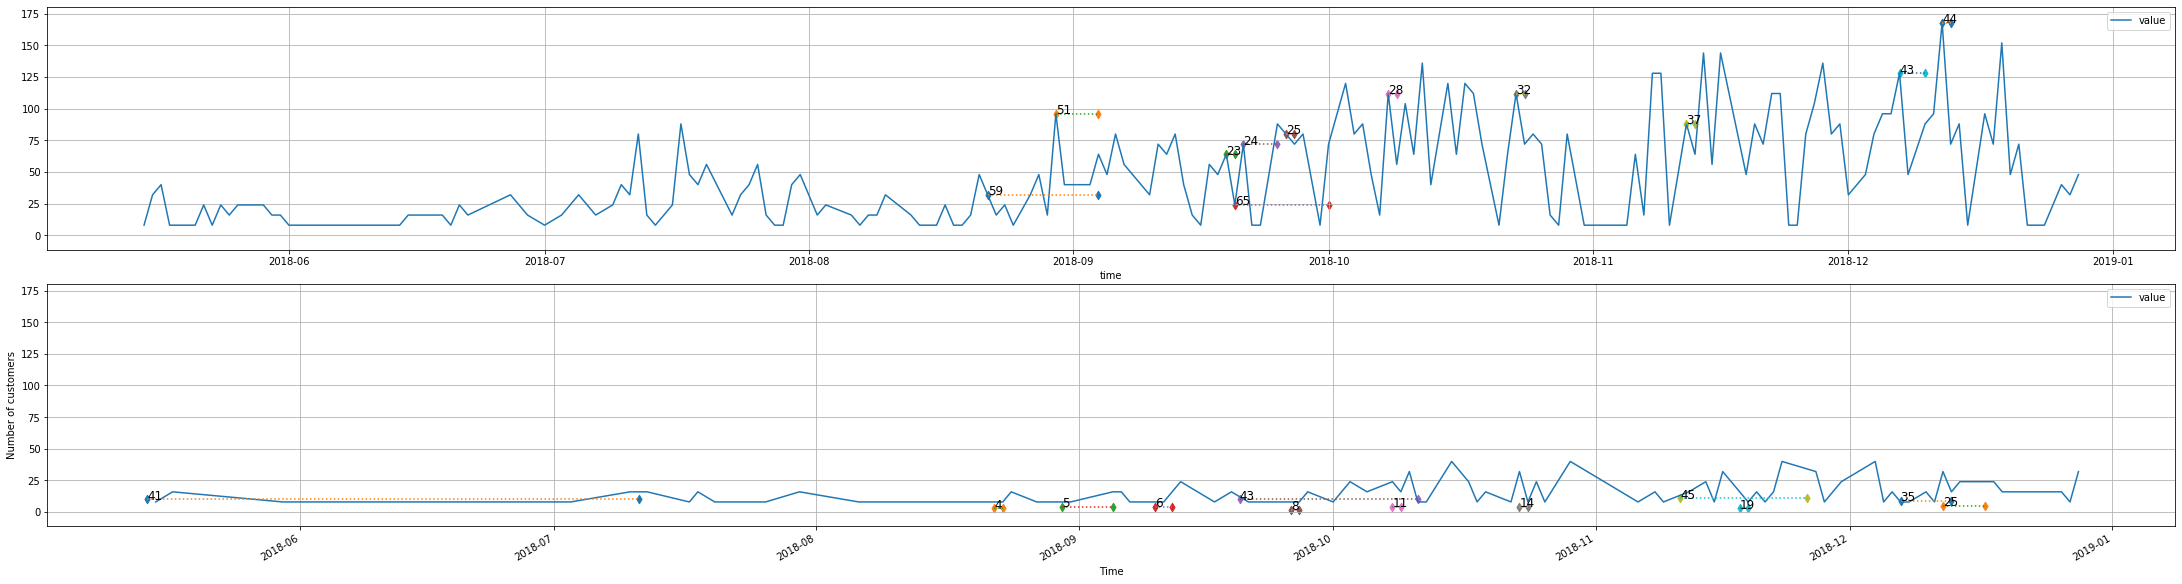

In [559]:
import numpy as np

fig, axs = plt.subplots(2, sharex=False, sharey=True,figsize=(15,5),)

snum = 'RAW-1D'
df = pd.read_sql(f"select * from measurement where snum='{snum}'",con=engine)
df.time = pd.to_datetime(df.time).dt.date
df = df[df.time>=min_date]
df.plot.line(ax=axs[0],x="time",y="value",figsize=(20,8),grid=True)
df= df.merge(all_customers_1.reset_index(),left_on="time",right_on="date",how="outer")
for idx,i in df.loc[df[["value_y","value_x"]].dropna().index].iterrows():
    date2 = i["date"]+timedelta(days=int(i["duration"].split(" ")[0]))
    axs[0].plot([i["date"],date2],[i["value_x"],i["value_x"]],':')
    axs[0].scatter([i["date"],date2],[i["value_x"],i["value_x"]],marker="d")
    axs[0].text(i["date"],i["value_x"],int(i["index"]),fontsize=12)

snum = 'RAW-SUBSET-1D'
df = pd.read_sql(f"select * from measurement where snum='{snum}'",con=engine)

df.plot.line(ax=axs[1],x="time",y="value",figsize=(30,8),grid=True)
df.time = pd.to_datetime(df.time).dt.date
df = df[df.time>=min_date]

df= df.merge(frequent_1.reset_index(),left_on="time",right_on="date",how="outer")
for idx,i in frequent_1.iterrows():
    date2 = i["date"]+timedelta(days=int(i["duration"].split(" ")[0]))
    axs[1].plot([i["date"],date2],[i["value"],i["value"]],':')
    axs[1].scatter([i["date"],date2],[i["value"],i["value"]],marker="d")
    axs[1].text(i["date"],i["value"],int(idx),fontsize=12)
axs[1].plot()  
fig.tight_layout(pad=0.3)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Number of customers',)
comparisons  


In [505]:
frequent_1

,customers,date,duration,value
41,"[770747, 539857, 907465, 897826, 815881, 14483...",2018-05-14,58 days,10
27,"[249608, 984430, 751640, 427096]",2018-06-17,22 days,4
1,"[984430, 751640, 427096]",2018-07-02,9 days,3
2,"[110899, 270220, 199984]",2018-07-16,1 days,3
28,"[427096, 751640]",2018-07-23,2 days,2
3,"[751640, 460754, 199984]",2018-07-25,4 days,3
42,"[218865, 110899, 449488, 777319, 427096, 31867...",2018-08-16,25 days,8
29,"[110899, 449488, 777319]",2018-08-19,3 days,3
4,"[777319, 427096, 318677]",2018-08-22,1 days,3
38,"[199984, 110899, 751640, 777319, 427096, 270220]",2018-08-26,17 days,6


[]

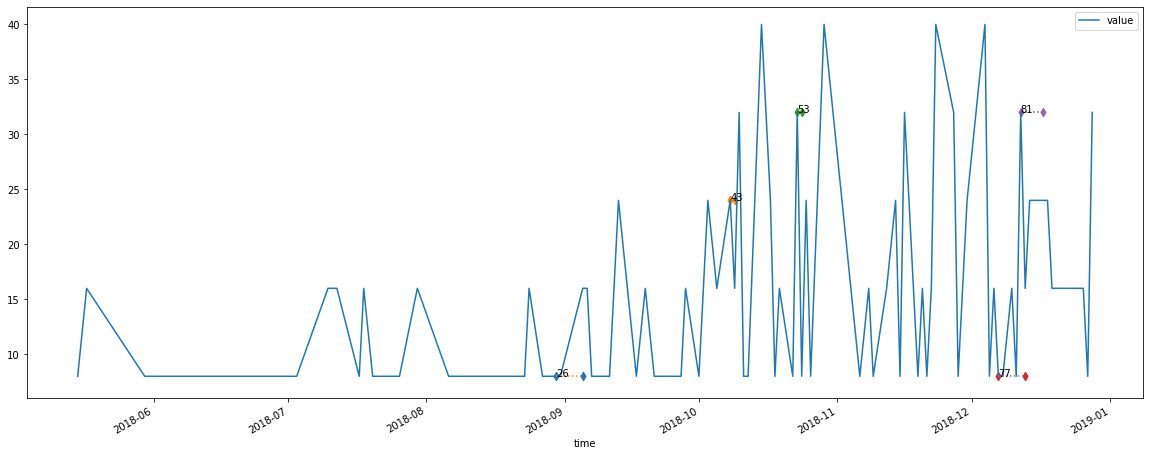

In [430]:
import numpy as np


snum = 'RAW-SUBSET-1D'
df = pd.read_sql(f"select * from measurement where snum='{snum}'",con=engine)

ax = df.plot.line(x="time",y="value",figsize=(20,8))
df.time = pd.to_datetime(df.time).dt.date
df= df.merge(frequent_1,left_on="time",right_on="date",how="outer")
for idx,i in df.loc[df[["value_y","value_x"]].dropna().index].iterrows():
    date2 = i["date"]+timedelta(days=int(i["duration"].split(" ")[0]))
    ax.plot([i["date"],date2],[i["value_x"],i["value_x"]],':')
    ax.scatter([i["date"],date2],[i["value_x"],i["value_x"]],marker="d")
    ax.text(i["date"],i["value_x"],idx)
ax.plot()

In [460]:
df

,sname,snum,time,value_x,metadata,customers,date,duration,value_y
0,RAW-SUBSET,RAW-SUBSET-1D,2018-05-15,8.0,"{'customers': '770747,770747,770747,770747,770...",NaN,NaN,NaN,NaN
1,RAW-SUBSET,RAW-SUBSET-1D,2018-05-17,16.0,"{'customers': '539857,907465,539857,907465,539...",NaN,NaN,NaN,NaN
2,RAW-SUBSET,RAW-SUBSET-1D,2018-05-30,8.0,"{'customers': '897826,897826,897826,897826,897...",NaN,NaN,NaN,NaN
3,RAW-SUBSET,RAW-SUBSET-1D,2018-06-06,8.0,"{'customers': '815881,815881,815881,815881,815...",NaN,NaN,NaN,NaN
4,RAW-SUBSET,RAW-SUBSET-1D,2018-06-07,8.0,"{'customers': '144834,144834,144834,144834,144...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
105,NaN,NaN,NaN,NaN,NaN,"[427096, 270220, 552846, 1178295, 1045120]",2018-10-04,3 days,5.0
106,NaN,NaN,NaN,NaN,NaN,"[270220, 199984]",2018-11-05,2 days,2.0
107,NaN,NaN,NaN,NaN,NaN,"[552846, 751640, 320135, 999796, 270220, 19998...",2018-11-11,15 days,11.0
108,NaN,NaN,NaN,NaN,NaN,"[127790, 270220, 552846]",2018-11-18,1 days,3.0


True

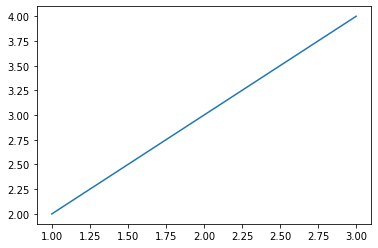

In [227]:
point1 = [1, 2]
point2 = [3, 4]

x_values = [point1[0], point2[0]]
gather x-values

y_values = [point1[1], point2[1]]
gather y-values


plt.plot(x_values, y_values)

In [311]:
frequent_2

,customers,date,duration,smoothIteration
0,"[270220, 1045120, 127790, 751640, 199984]",2018-09-30 22:00:00+00:00,2 days,0
1,"[427096, 270220, 552846, 1178295, 1045120]",2018-10-04 22:00:00+00:00,3 days,0
2,"[270220, 1045120, 127790, 427096, 552846]",2018-10-10 22:00:00+00:00,4 days,1
3,"[127790, 999796, 110899, 552846, 270220]",2018-10-25 22:00:00+00:00,3 days,0
4,"[127790, 552846, 751640, 320135, 999796]",2018-11-08 23:00:00+00:00,5 days,0
5,"[552846, 270220, 199984, 427096, 751640]",2018-11-14 23:00:00+00:00,1 days,0
6,"[270220, 552846, 127790, 777319, 751640]",2018-11-19 23:00:00+00:00,3 days,1
7,"[427096, 552846, 344696, 109054, 751640, 12779...",2018-11-27 23:00:00+00:00,6 days,0
8,"[1045120, 109054, 127790, 552846, 427096]",2018-12-10 23:00:00+00:00,1 days,0
9,"[777319, 110899, 751640, 270220, 427096]",2018-12-12 23:00:00+00:00,5 days,0


In [209]:
subset = df[["TRANSACTION_DATE","CUST_ID","ARTICLE_ID"]].drop_duplicates()
subset.columns = map(str.lower, subset.columns)
subset.to_sql("transactions",con=engine,if_exists="append",index=False)

In [194]:
customers

[397538,
 231687,
 328105,
 1104212,
 146423,
 319243,
 157246,
 407312,
 1033518,
 604562,
 687941,
 137685,
 445292,
 223788,
 118067,
 912398,
 146710,
 116610,
 600391,
 168223,
 221900,
 180086,
 152685,
 556050,
 505454,
 460243,
 1005729,
 185342,
 834533,
 141443,
 217903,
 195078,
 188629,
 343142,
 651647,
 107727,
 116517,
 1055191,
 341717,
 454300,
 323618,
 457688,
 518655,
 1173623,
 887117,
 148931,
 357876,
 365101,
 406959,
 964878,
 203468,
 105524,
 336318,
 284530,
 1023595,
 1012953,
 103240,
 1107311,
 115022,
 804972,
 423611,
 212029,
 410571,
 805158,
 249904,
 717621,
 274953,
 876768,
 599789,
 876693,
 189283,
 274871,
 440533,
 362989,
 379448,
 251350,
 876237,
 152633,
 560864,
 437974,
 252704,
 176750,
 402831,
 164231,
 1199522,
 147391,
 149886,
 508797,
 1003223,
 130527,
 764005,
 1164511,
 347942,
 177693,
 125034,
 150269,
 157287,
 317586,
 164308,
 474879,
 126277,
 120248,
 110455,
 273864,
 1028559,
 105193,
 214066,
 532504,
 465567,
 498303